# LINEAR REGRESSION
In this notebook, we will implement linear regression and apply it to our dataset. We will use the dataset we previously built and preprocessed.
We will use the `scikit-learn` library for implementation and also include a manual implementation for comparison.

## Project setup
### Install the necessary libraries
We begin by importing the necessary libraries for data manipulation, model building, and evaluation. These include `pandas`, `numpy`, and several modules from `scikit-learn`. Additionally, we import visualization libraries such as `matplotlib` and `seaborn`.

In [16]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import seaborn as sns

from helpers import plot_variable_importance, write_metrics_in_csv, plot_ypred_vs_yreal

### Load the dataset
Next, we load our preprocessed dataset. We remove any columns that are not needed for our analysis to streamline the dataset.

In [17]:
# Open dataset
filename: str = 'dataRead_processed.pkl.bz2'
dataset = pd.read_pickle(filename, compression='bz2')

### Split the dataset and set the final preprocessing steps
We separate the dataset into features ($X$) and the target variable ($y$). Further, we identify numerical and categorical features for preprocessing.
We prepare a preprocessing pipeline that standardizes numerical features and one-hot encodes categorical features.

In [18]:
# Drop columns that are not needed
dataset = dataset.drop(columns=[
    'city_attraction_area',
    'non_scholarized_15_years_old_or_more_2020',
    ])

# Split the dataset into features and target variable
X = dataset.drop('total_passengers_2022', axis=1)
y = dataset['total_passengers_2022']

# Last preprocessing steps
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns


# Prepare the final preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

## Scikit learn regression model
We create a pipeline for linear regression, splitting the dataset into training and testing sets. The model is then trained and evaluated.

,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,linear_regression,{'tuning': None},4.232696e+10,54041.449279,20135.87193,0.968842


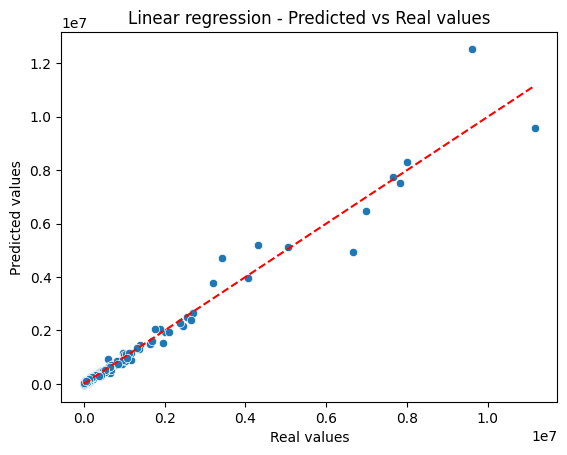

In [42]:

# Create the final pipeline
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Separate the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
linear_model.fit(X_train, y_train)

# Predict the target variable
y_pred_linear = linear_model.predict(X_test)

# Write metrics in a csv file
mse = mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

plot_ypred_vs_yreal(y_pred_linear, y_test, 'Linear regression', False, True)

write_metrics_in_csv(y_pred_linear,
                     y_test,
                     'linear_regression',
                     {'tuning': None}
                     )

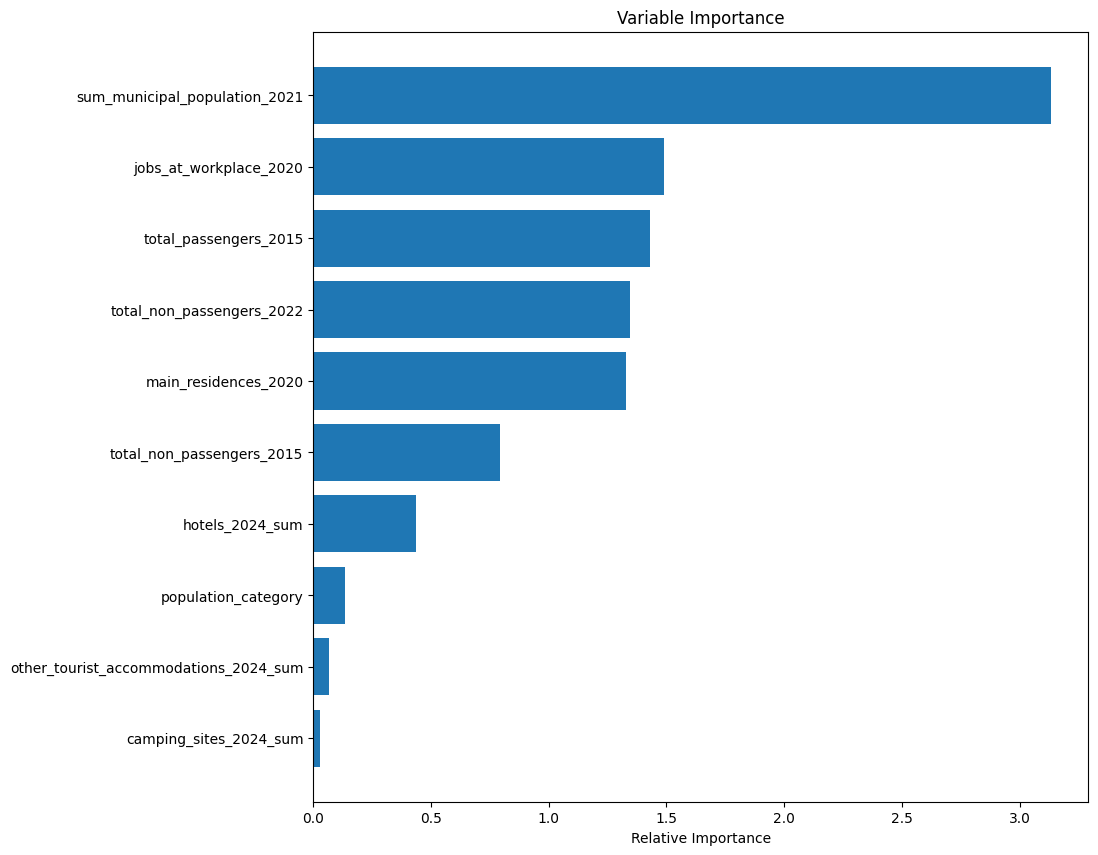

In [43]:
plot_variable_importance(linear_model, X_train, y_train, 10)

/Users/pierrejezegou/Documents/FIB/fib-ml-project/helpers.py:89: RuntimeWarning: invalid value encountered in log
  y_pred = np.log(y_pred)


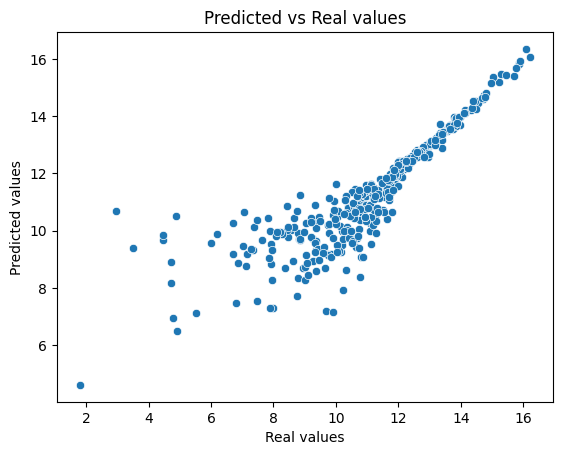

In [21]:
plot_ypred_vs_yreal(y_pred_linear, y_test, False, True)

## Ridge regularization
To avoid unwanted too complex model and overfitting, we will use Ridge regularization. Ridge regression adds a penalty term to the cost function. The penalty term is the sum of the squares of the coefficients multiplied by the regularization parameter alpha. The regularization parameter alpha is a hyperparameter that controls the strength of the penalty term. The larger the alpha, the stronger the regularization.

To avoid overfitting and keep the model complexity in check, we employ Ridge regularization, which adds a penalty term to the cost function.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

param_grid = {
    'regressor__alpha': [10**i for i in range(-3, 3)],
    'regressor__fit_intercept': [True, False],
    'regressor__tol': [1e-4, 1e-3, 1e-2],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

# Create the final pipeline with Ridge regression
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Grid search with cross-validation to find the best hyperparameters for the Ridge regression model
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(grid_search.best_params_)

/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: C

{'regressor__alpha': 1, 'regressor__fit_intercept': False, 'regressor__solver': 'saga', 'regressor__tol': 0.001}


In [23]:
# Train the model with the best hyperparameters
ridge_model = grid_search.best_estimator_

# Predict the target variable
y_pred_ridge = ridge_model.predict(X_test)

# Write metrics in a csv file
write_metrics_in_csv(y_pred_ridge, y_test, 'ridge_regression', grid_search.best_params_)


,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,ridge_regression,"{'regressor__alpha': 1, 'regressor__fit_interc...",4.361706e+10,52408.776245,14961.637565,0.967892


/Users/pierrejezegou/Documents/FIB/fib-ml-project/helpers.py:89: RuntimeWarning: invalid value encountered in log
  y_pred = np.log(y_pred)


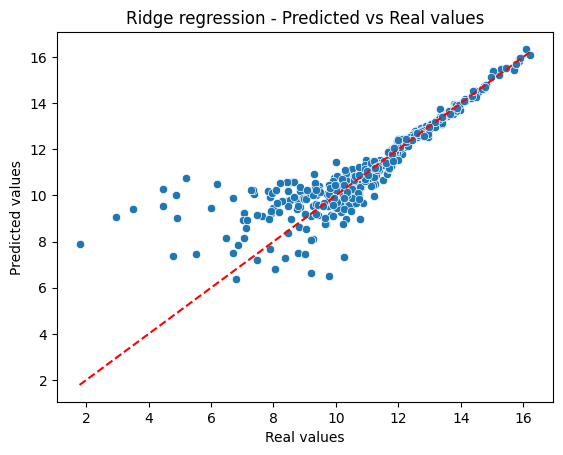

In [24]:
plot_ypred_vs_yreal(y_pred_ridge, y_test, 'Ridge regression', True, True)

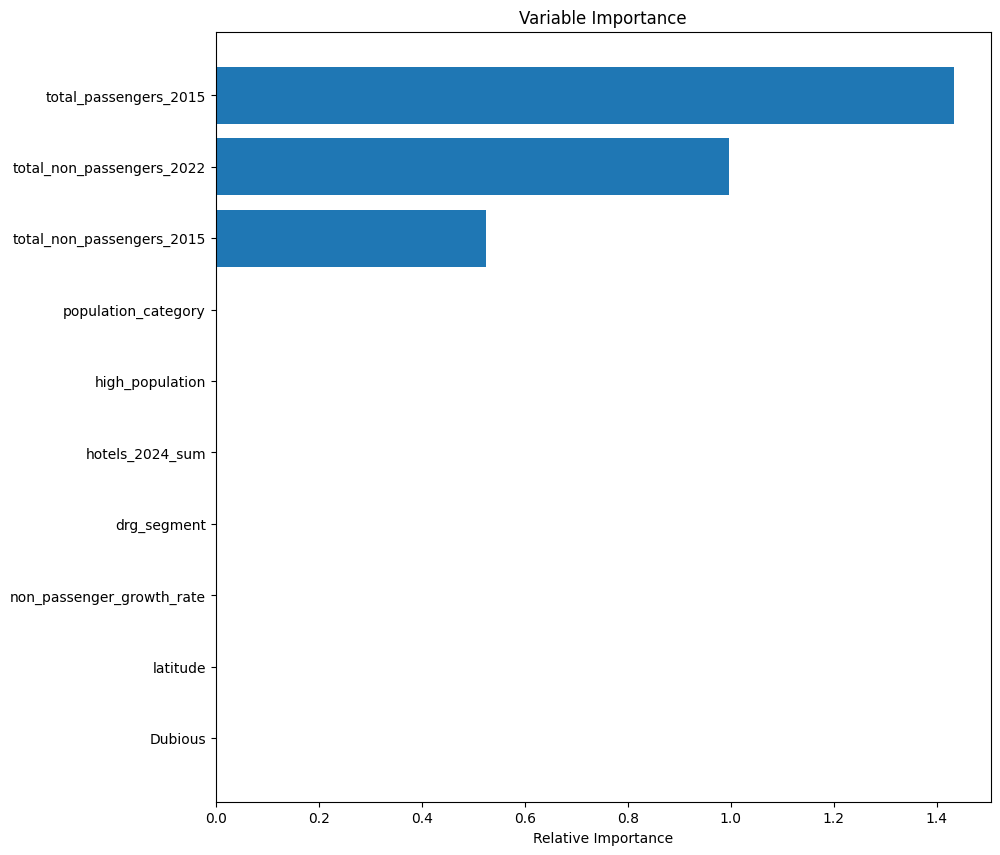

In [25]:
plot_variable_importance(ridge_model, X_train, y_train, 10)

## Lasso regularization
We also explore Lasso regularization, which can set some coefficients to zero, effectively performing feature selection.

### Modle implementation

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

param_grid = {
    'regressor__alpha': [10**i for i in range(-3, 3)],  # Réglage de l'alpha pour Lasso
    'regressor__fit_intercept': [True, False],          # Option pour inclure ou non l'intercept
    'regressor__tol': [1e-4, 1e-3, 1e-2],               # Tolérance pour l'optimisation
    'regressor__selection': ['cyclic', 'random']        # Stratégie de sélection pour l'optimisation
}

# Create the final pipeline with Lasso regression model
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Use grid search with cross-validation to find the best hyperparameters for the Lasso regression model
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(grid_search.best_params_)

/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e+13, tolerance: 3.402e+11
  model = cd_fast.enet_coordinate_descent(
/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+13, tolerance: 2.835e+11
  model = cd_fast.enet_coordinate_descent(
/Users/pierrejezegou/Documents/FIB/fib-ml-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the

{'regressor__alpha': 1, 'regressor__fit_intercept': False, 'regressor__selection': 'random', 'regressor__tol': 0.01}


In [27]:
# Train the model with the best hyperparameters
lasso_model = grid_search.best_estimator_

# Predict the target variable
y_pred_lasso = ridge_model.predict(X_test)

# Write metrics in a csv file
write_metrics_in_csv(y_pred_ridge, y_test, 'ridge_regression', grid_search.best_params_)


,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,ridge_regression,"{'regressor__alpha': 1, 'regressor__fit_interc...",4.361706e+10,52408.776245,14961.637565,0.967892


### Analyzing the results

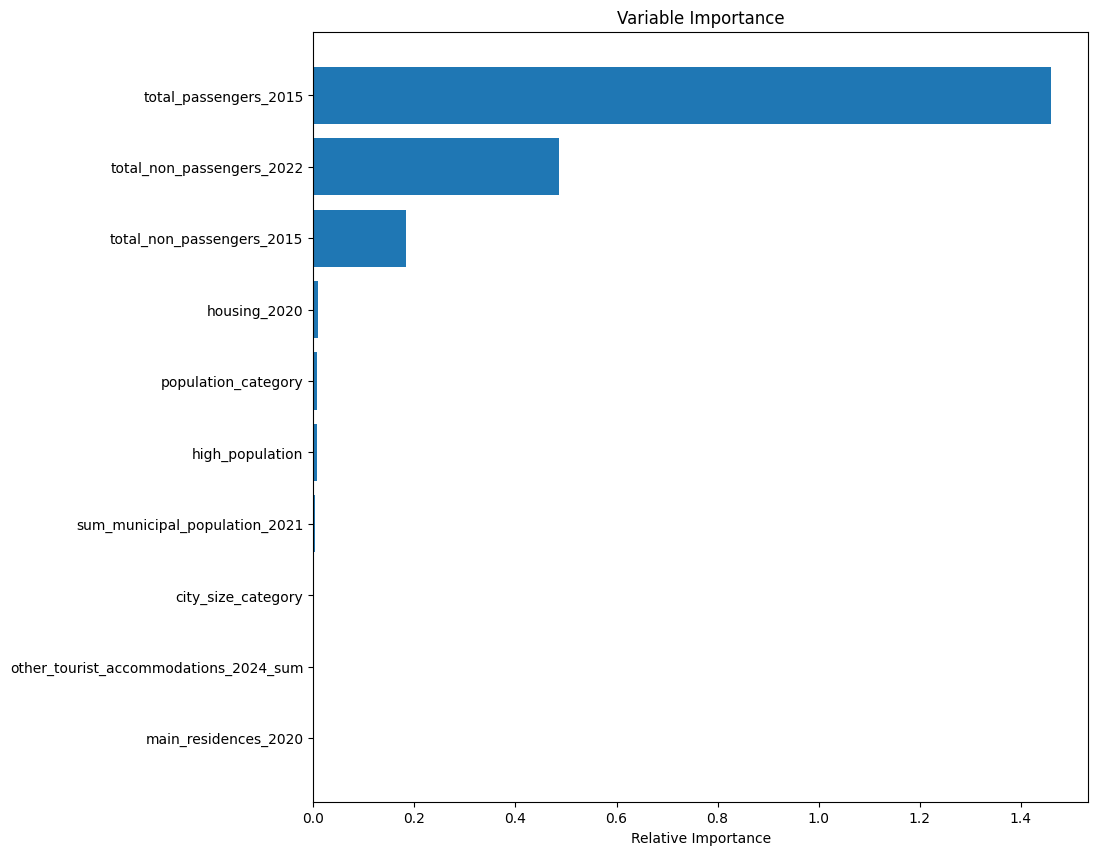

In [28]:
plot_variable_importance(lasso_model, X_train, y_train, 10)

## Compare models

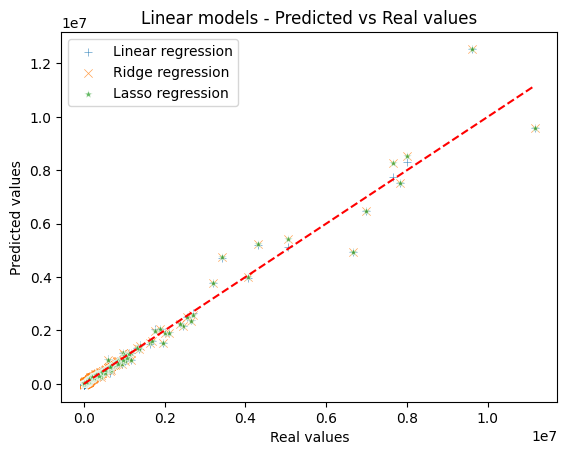

In [29]:
# Add labels
plt.xlabel('Real values')
plt.ylabel('Predicted values')

plt.title(f'Linear models - Predicted vs Real values')

# Plot
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.75, marker='+', label='Linear regression')
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.75, marker='x', label='Ridge regression')
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.75, marker='*', label='Lasso regression')

# # x, yin log scale
# plt.xscale('log')
# plt.yscale('log')

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], '--', color='red')

## Try to fix features
### Learning curves to detect overfitting
Learning curves plot the model’s performance on the training set and the validation set as a function of the number of training samples. They can help to visualize overfitting. If the training error is low but the validation error is high, the model is likely overfitting.

In [48]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


def learning_curve_plot(model, model_name: str, X: pd.DataFrame, y: pd.Series, train_sizes: int = 10) -> None:
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, train_sizes))

    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, val_scores_mean, label='Validation error')
    plt.ylabel('MSE')
    plt.xlabel('Training size')
    plt.title(f'{model_name} - Learning curves')
    plt.legend()
    plt.show()

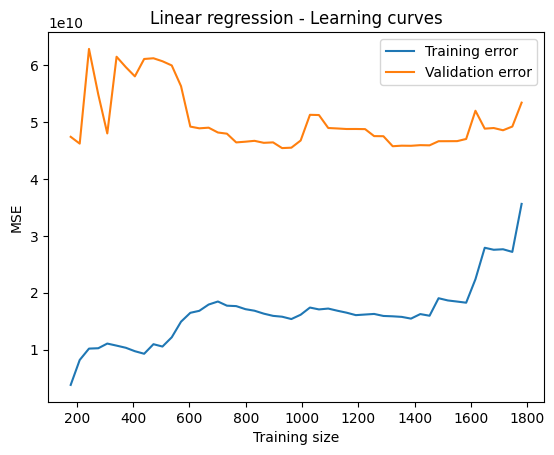

In [46]:
learning_curve_plot(linear_model, 'Linear regression', X, y)

We have a 5x difference between the training and validation scores for linear regression, which indicates small overfitting. We can try to fix this by adding more training samples or reducing the model complexity. Lets try with Ridge and Lasso regularization.

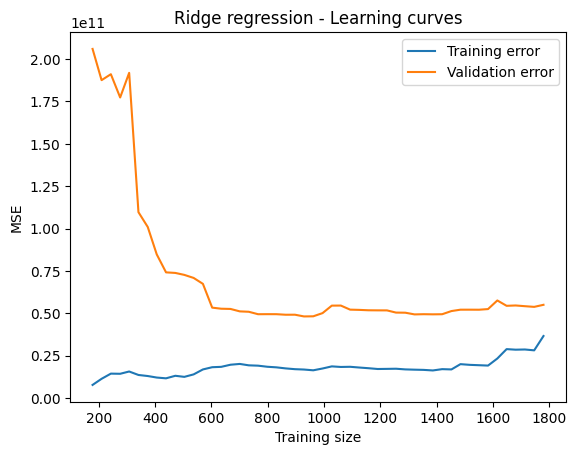

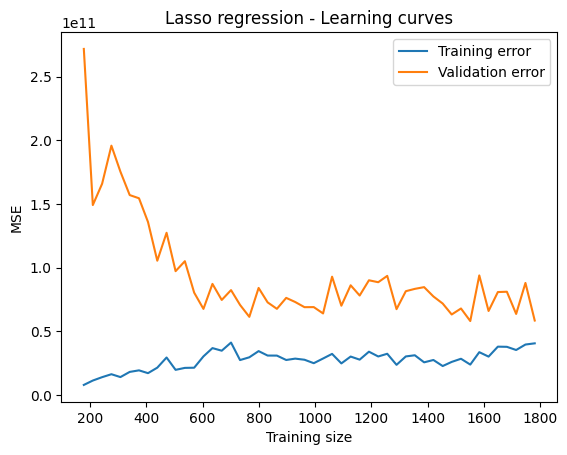

In [50]:
learning_curve_plot(ridge_model, 'Ridge regression', X, y, 50)
learning_curve_plot(lasso_model, 'Lasso regression', X, y, 50)

For reasonable train size, we can see that the model is not overfitting. Indeed, the training and validation scores are not too far apart.